In [71]:
import numpy as np
import pandas as pd
import seaborn as sns   
import mibian
import time
import datetime
from matplotlib import pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [72]:
def process_data(df, symbol, sector, call):
    # choose sector, otherwise choose specific stock symbol
    symbol_df = df[df.Sector==symbol] if sector else df[df.Symbol==symbol] 
    symbol_df = symbol_df[symbol_df['Call'] == 1] if call else symbol_df[symbol_df['Call'] == 0]
    symbol_df.columns = symbol_df.columns.str.strip()

    symbol_df = symbol_df.replace({'In the Money': {'True':1, 'False':0}})
    symbol_df = symbol_df.replace({'In the Money': {True:1, False:0}})
    symbol_df = symbol_df.replace({'Call': {True:1,False:0}})

    # columns to drop for our input feature vector
    columns = ['Symbol','Expiration Date', 'Sector', 'Industry', 'Record Time', 'Profit']
    symbol_df = symbol_df.drop(columns=columns)
    
    failed_len = len(symbol_df[symbol_df['Success'] == 0])
    
    count = len(symbol_df[symbol_df['Success'] == 1])
    if count < failed_len:
        count_failed = count * 3 if failed_len > count * 3 else count * 2
        count_failed = count_failed if failed_len > count_failed else count
    else:
        count_failed = failed_len
    
    failed_df = symbol_df.loc[symbol_df['Success'] == 0].sample(n=count_failed,random_state=42)
    success_df = symbol_df.loc[symbol_df['Success'] == 1]
    
    return pd.concat([failed_df, success_df])

In [73]:
# Scraped yahoo data
options_data_3_11_df = pd.read_csv('../yahooData/results/finalData_3-11.csv', delimiter=',', encoding='unicode_escape')
options_data_3_18_df = pd.read_csv('../yahooData/results/finalData_3-18.csv', delimiter=',', encoding='unicode_escape')
options_data_3_25_df = pd.read_csv('../yahooData/results/finalData_3-25.csv', delimiter=',', encoding='unicode_escape')
options_data_4_01_df = pd.read_csv('../yahooData/results/finalData_4-01.csv', delimiter=',', encoding='unicode_escape')
options_data_4_08_df = pd.read_csv('../yahooData/results/finalData_4-08.csv', delimiter=',', encoding='unicode_escape')
options_data_4_15_df = pd.read_csv('../yahooData/results/finalData_4-15.csv', delimiter=',', engine='python', encoding='unicode_escape')
options_data_4_22_df = pd.read_csv('../yahooData/results/finalData_4-22.csv', delimiter=',', encoding='unicode_escape')

options_data_3_11_df_c = process_data(options_data_3_11_df, 'Technology', True, True)
options_data_3_18_df_c = process_data(options_data_3_18_df, 'Technology', True, True)
options_data_3_25_df_c = process_data(options_data_3_25_df, 'Technology', True, True)
options_data_4_01_df_c = process_data(options_data_4_01_df, 'Technology', True, True)
options_data_4_08_df_c = process_data(options_data_4_08_df, 'Technology', True, True)
options_data_4_15_df_c = process_data(options_data_4_15_df, 'Technology', True, True)
options_data_4_22_df_c = process_data(options_data_4_22_df, 'Technology', True, True)

calls_df = pd.concat([options_data_3_11_df_c, options_data_3_18_df_c, options_data_3_25_df_c, options_data_4_01_df_c, options_data_4_08_df_c, options_data_4_15_df_c])
options7call_df = pd.concat([options_data_4_15_df_c, options_data_4_22_df_c])

options_data_3_11_df_p = process_data(options_data_3_11_df, 'Technology', True, False)
options_data_3_18_df_p = process_data(options_data_3_18_df, 'Technology', True, False)
options_data_3_25_df_p = process_data(options_data_3_25_df, 'Technology', True, False)
options_data_4_01_df_p = process_data(options_data_4_01_df, 'Technology', True, False)
options_data_4_08_df_p = process_data(options_data_4_08_df, 'Technology', True, False)
options_data_4_15_df_p = process_data(options_data_4_15_df, 'Technology', True, False)
options_data_4_22_df_p = process_data(options_data_4_22_df, 'Technology', True, False)

puts_df = pd.concat([options_data_3_11_df_p, options_data_3_18_df_p, options_data_3_25_df_p, options_data_4_01_df_p, options_data_4_08_df_p, options_data_4_15_df_p])
options7put_df = pd.concat([options_data_4_22_df_p, options_data_4_22_df_p])

In [74]:
def run_random_forest_model(features, train_df, test_df, scaled=False, call=True, profit=False):
    X_train = train_df
    y_train = np.ravel(X_train[['Success']])
    X_train = X_train[features]

    # feature scaling
    scaler = StandardScaler()
    scaler.fit(X_train)

    # scaled data
    X_train_scaled = scaler.transform(X_train) if scaled else X_train

    # scale the 3-18 data based on the stats from 3-11 data
    # sample ~1000 data points for 80/20 split
    X_test = test_df
    y_test = np.ravel(X_test[['Success']])
    X_test = X_test[features]
    
    X_test_scaled = scaler.transform(X_test) if scaled else X_test

    # # 80/20 train/test split
    # we have determined 5/2 week split should be used over 7 week shuffling 
    # X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
    
    # never hurts to use more trees (n_estimators), only downside is computation time
    # --> for all runs, we simply use n_estimators = 100 (not much more are really necessary, especially
    #                                                    considering that we only use 4 features at max)
    random_forest_model = RandomForestClassifier(n_estimators=100)
    random_forest_model.fit(X_train_scaled, y_train)
    y = random_forest_model.predict(X_test_scaled)
    
    score = random_forest_model.score(X_test_scaled, y_test)
    prec = list(precision_recall_fscore_support(y_test, y, average='macro'))
    prec[-1] = score
    
    # feature selection using 
    features = pd.Series(random_forest_model.feature_importances_,index=X_train.columns).sort_values(ascending=True)
    
    if profit:
        X_test = test_df.reset_index(drop=True).drop('Success', axis=1)
        X_profitability = pd.concat([X_test, pd.DataFrame(y)], axis=1, ignore_index=True)
        X_profitability.columns = test_df.columns
        X_profitability["Profit"] = X_profitability["Final Price"] - X_profitability["Breakeven Price"] if call else X_profitability["Breakeven Price"] - X_profitability["Final Price"]
        # Uncomment to plot the profit for each option against any of the columns
        sns.lineplot(data=X_profitability, x="Days to Expire", y="Profit", hue="Success")
        plt.show()
        profit =  X_profitability.loc[X_profitability['Success'] == 1].Profit.sum()
        prec.append(profit)
        profit_percent =  100 * profit / X_profitability.loc[X_profitability['Success'] == 1].Mark.sum()
        prec.append(profit_percent)
        display(pd.DataFrame({"Metric:": ["Precision", "Recall", "F1", "Accuracy", "Profitability", "Profit Percent"], "Results:":prec}))
    else:    
        display(pd.DataFrame({"Metric:": ["Precision", "Recall", "F1", "Accuracy"], "Results:":prec}))
    
    return features

CALLS 4 features, 2 features, 2 features

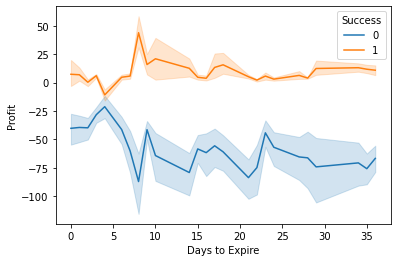

,Metric:,Results:
0,Precision,0.951733
1,Recall,0.939128
2,F1,0.945207
3,Accuracy,0.959473
4,Profitability,5486.405000
5,Profit Percent,16.232047


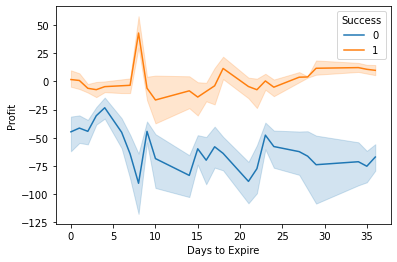

,Metric:,Results:
0,Precision,0.846676
1,Recall,0.887044
2,F1,0.863208
3,Accuracy,0.891113
4,Profitability,2690.425000
5,Profit Percent,7.066991


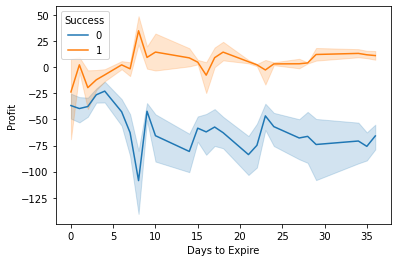

,Metric:,Results:
0,Precision,0.907427
1,Recall,0.921875
2,F1,0.914301
3,Accuracy,0.934570
4,Profitability,3686.400000
5,Profit Percent,10.667883


Days to Expire        0.08536
Implied Volatility    0.91464
dtype: float64

In [78]:
run_random_forest_model(['Implied Volatility', 'In the Money', 'Days to Expire', 'Needed Percent Change'], calls_df, options7call_df, False, True, True)
run_random_forest_model(['Needed Percent Change', 'In the Money'], calls_df, options7call_df, False, True, True)
run_random_forest_model(['Implied Volatility', 'Days to Expire'], calls_df, options7call_df, False, True, True)

CALLS final 4 features

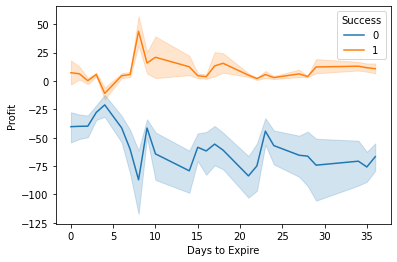

,Metric:,Results:
0,Precision,0.950984
1,Recall,0.937174
2,F1,0.943811
3,Accuracy,0.958496
4,Profitability,5475.240000
5,Profit Percent,16.203010


In the Money             0.130709
Days to Expire           0.137158
Implied Volatility       0.258296
Needed Percent Change    0.473837
dtype: float64

In [79]:
run_random_forest_model(['Implied Volatility', 'Days to Expire', 'Needed Percent Change', 'In the Money'], calls_df, options7call_df, False, True, True)

PUTS 4 features, 2 features, 2 features

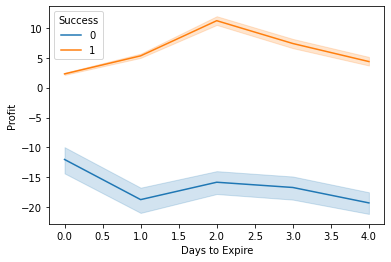

,Metric:,Results:
0,Precision,0.855922
1,Recall,0.851840
2,F1,0.851414
3,Accuracy,0.851840
4,Profitability,16408.050000
5,Profit Percent,42.410391


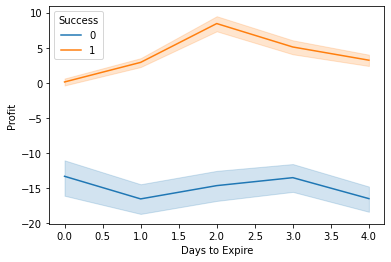

,Metric:,Results:
0,Precision,0.760658
1,Recall,0.757884
2,F1,0.757239
3,Accuracy,0.757884
4,Profitability,10494.710000
5,Profit Percent,28.624120


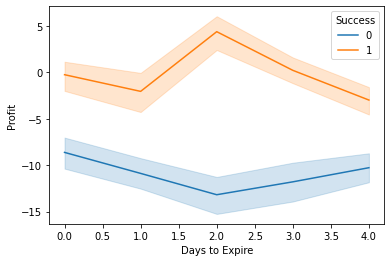

,Metric:,Results:
0,Precision,0.648702
1,Recall,0.643561
2,F1,0.640453
3,Accuracy,0.643561
4,Profitability,-480.150000
5,Profit Percent,-2.137946


Days to Expire        0.08724
Implied Volatility    0.91276
dtype: float64

In [80]:
run_random_forest_model(['Implied Volatility', 'In the Money', 'Days to Expire', 'Needed Percent Change'], puts_df, options7put_df, False, False, True)
run_random_forest_model(['Needed Percent Change', 'In the Money'], puts_df, options7put_df, False, False, True)
run_random_forest_model(['Implied Volatility', 'Days to Expire'], puts_df, options7put_df, False, False, True)

PUTS final 4 features

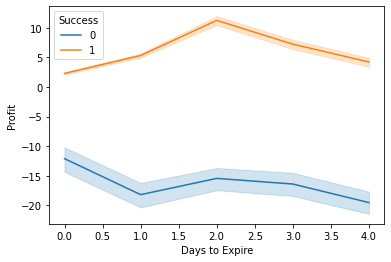

,Metric:,Results:
0,Precision,0.851960
1,Recall,0.847569
2,F1,0.847092
3,Accuracy,0.847569
4,Profitability,16071.610000
5,Profit Percent,42.310111


In the Money             0.079404
Days to Expire           0.117858
Implied Volatility       0.253540
Needed Percent Change    0.549198
dtype: float64

In [81]:
run_random_forest_model(['Implied Volatility', 'Days to Expire', 'Needed Percent Change', 'In the Money'], puts_df, options7put_df, False, False, True)

# With Black Scholes

In [82]:
def callDelta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callDelta

def callTheta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callTheta

def callRho(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callRho

def callVega(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.vega

def callGamma(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.gamma

def putDelta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putDelta

def putTheta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putTheta

def putRho(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putRho

def putVega(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.vega

def putGamma(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.gamma

In [83]:
start_time = time.time()

calls_df_bs = calls_df.copy()
options7call_df_bs = options7call_df.copy()

calls_df_bs['Delta'] = calls_df_bs.apply(lambda row: callDelta(row), axis=1)
calls_df_bs['Theta'] = calls_df_bs.apply(lambda row: callTheta(row), axis=1)
calls_df_bs['Rho'] = calls_df_bs.apply(lambda row: callRho(row), axis=1)
calls_df_bs['Vega'] = calls_df_bs.apply(lambda row: callVega(row), axis=1)
calls_df_bs['Gamma'] = calls_df_bs.apply(lambda row: callGamma(row), axis=1)

options7call_df_bs['Delta'] = options7call_df.apply(lambda row: callDelta(row), axis=1)
options7call_df_bs['Theta'] = options7call_df.apply(lambda row: callTheta(row), axis=1)
options7call_df_bs['Rho'] = options7call_df.apply(lambda row: callRho(row), axis=1)
options7call_df_bs['Vega'] = options7call_df.apply(lambda row: callVega(row), axis=1)
options7call_df_bs['Gamma'] = options7call_df.apply(lambda row: callGamma(row), axis=1)

puts_df_bs = puts_df.copy()
options7put_df_bs = options7put_df.copy()

puts_df_bs['Delta'] = puts_df_bs.apply(lambda row: putDelta(row), axis=1)
puts_df_bs['Theta'] = puts_df_bs.apply(lambda row: putTheta(row), axis=1)
puts_df_bs['Rho'] = puts_df_bs.apply(lambda row: putRho(row), axis=1)
puts_df_bs['Vega'] = puts_df_bs.apply(lambda row: putVega(row), axis=1)
puts_df_bs['Gamma'] = puts_df_bs.apply(lambda row: putGamma(row), axis=1)

options7put_df_bs['Delta'] = options7put_df_bs.apply(lambda row: putDelta(row), axis=1)
options7put_df_bs['Theta'] = options7put_df_bs.apply(lambda row: putTheta(row), axis=1)
options7put_df_bs['Rho'] = options7put_df_bs.apply(lambda row: putRho(row), axis=1)
options7put_df_bs['Vega'] = options7put_df_bs.apply(lambda row: putVega(row), axis=1)
options7put_df_bs['Gamma'] = options7put_df_bs.apply(lambda row: putGamma(row), axis=1)

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

Took 0:08:06.124410 seconds


In [84]:
calls_df_bs_success = calls_df_bs.pop("Success")
calls_df_bs.insert(len(calls_df_bs.columns), calls_df_bs_success.name, calls_df_bs_success)

options7call_df_bs_success = options7call_df_bs.pop("Success")
options7call_df_bs.insert(len(options7call_df_bs.columns), options7call_df_bs_success.name, options7call_df_bs_success)

puts_df_bs_success = puts_df_bs.pop("Success")
puts_df_bs.insert(len(puts_df_bs.columns), puts_df_bs_success.name, puts_df_bs_success)

options7put_df_bs_success = options7put_df_bs.pop("Success")
options7put_df_bs.insert(len(options7put_df_bs.columns), options7put_df_bs_success.name, options7put_df_bs_success)

CALLS lr selected features

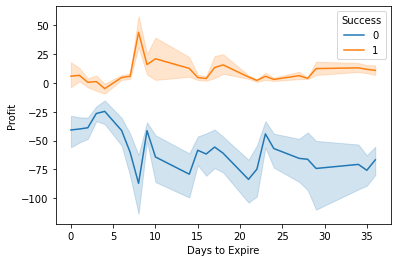

,Metric:,Results:
0,Precision,0.954041
1,Recall,0.940755
2,F1,0.947152
3,Accuracy,0.960938
4,Profitability,5540.055000
5,Profit Percent,16.370617


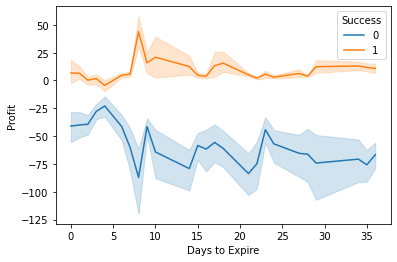

,Metric:,Results:
0,Precision,0.956357
1,Recall,0.942383
2,F1,0.949099
3,Accuracy,0.962402
4,Profitability,5607.595000
5,Profit Percent,16.567468


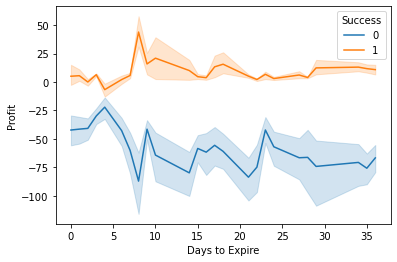

,Metric:,Results:
0,Precision,0.947794
1,Recall,0.943685
2,F1,0.945715
3,Accuracy,0.959473
4,Profitability,5601.685000
5,Profit Percent,16.413075


Vega                  0.110098
Gamma                 0.118958
Theta                 0.146338
Implied Volatility    0.166751
Rho                   0.201696
Delta                 0.256159
dtype: float64

In [85]:
run_random_forest_model(['Needed Percent Change','Days to Expire',  'Volume', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], calls_df_bs, options7call_df_bs, False, True, True)
run_random_forest_model(['Needed Percent Change', 'Volume', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], calls_df_bs, options7call_df_bs, False, True, True)
run_random_forest_model(['Implied Volatility', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], calls_df_bs, options7call_df_bs, False, True, True)

CALLS final all features

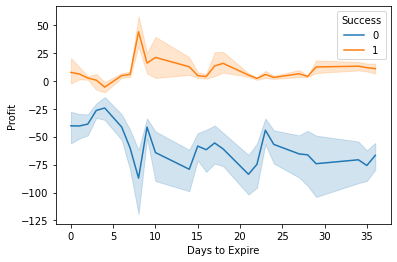

,Metric:,Results:
0,Precision,0.953670
1,Recall,0.939779
2,F1,0.946455
3,Accuracy,0.960449
4,Profitability,5540.670000
5,Profit Percent,16.394009


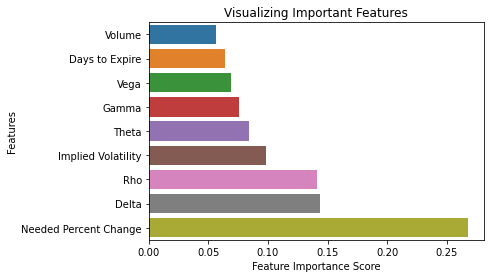

In [86]:
features = run_random_forest_model(['Implied Volatility', 'Volume', 'Days to Expire', 'Needed Percent Change', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], calls_df_bs, options7call_df_bs, False, True, True)

# Creating a bar plot
sns.barplot(x=features, y=features.index, orient="h")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

PUTS lr selected features

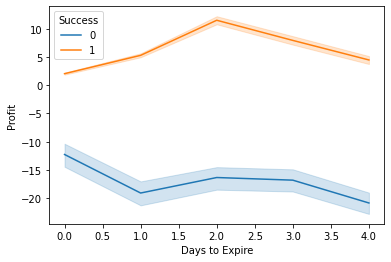

,Metric:,Results:
0,Precision,0.872338
1,Recall,0.869580
2,F1,0.869338
3,Accuracy,0.869580
4,Profitability,17244.070000
5,Profit Percent,42.483176


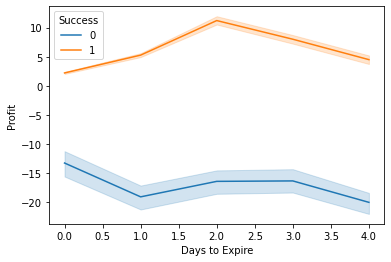

,Metric:,Results:
0,Precision,0.875446
1,Recall,0.872536
2,F1,0.872289
3,Accuracy,0.872536
4,Profitability,17058.640000
5,Profit Percent,42.101865


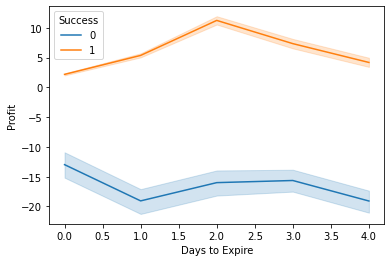

,Metric:,Results:
0,Precision,0.857899
1,Recall,0.854139
2,F1,0.853755
3,Accuracy,0.854139
4,Profitability,16165.820000
5,Profit Percent,39.513040


Vega                  0.104314
Gamma                 0.122497
Theta                 0.134600
Implied Volatility    0.155865
Rho                   0.187370
Delta                 0.295355
dtype: float64

In [87]:
run_random_forest_model(['Needed Percent Change', 'Days to Expire', 'Volume','Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], puts_df_bs, options7put_df_bs, False, False, True)
run_random_forest_model(['Needed Percent Change', 'Volume','Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], puts_df_bs, options7put_df_bs, False, False, True)
run_random_forest_model(['Implied Volatility', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], puts_df_bs, options7put_df_bs, False, False, True)

PUTS final all features

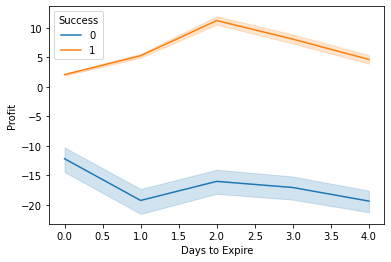

,Metric:,Results:
0,Precision,0.871461
1,Recall,0.867608
2,F1,0.867264
3,Accuracy,0.867608
4,Profitability,17093.180000
5,Profit Percent,42.797489


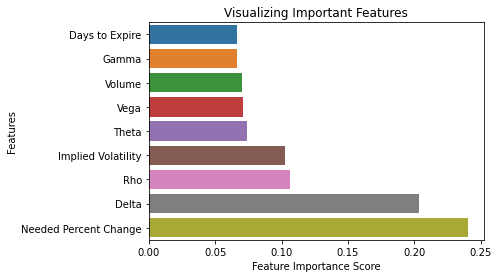

In [88]:
features = run_random_forest_model(['Implied Volatility', 'Volume', 'Days to Expire', 'Needed Percent Change', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma'], puts_df_bs, options7put_df_bs, False, False, True)

# Creating a bar plot
sns.barplot(x=features, y=features.index, orient="h")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Below is the code previously used to perform stock-wise normalization for random forest model. Since we have determined that the features for the model do not require stock-wise normalizing (in the money, needed percent change, implied volatility, and days to expire), we can simply use StandardScaler() instead.

In [108]:
# choose tech sector
tech_df = puts_df[puts_df.Sector=='Technology']
tech_df = tech_df.drop(columns=['Call', 'Sector'])

stock_frames = []
tech_stock_names = tech_df['Symbol'].unique()

# output
y = tech_df['Success']
tech_df = tech_df.drop(columns=['Success'])

# columns to normalize
col_to_norm = ['Strike', 'Current Price', 'Implied Volatility', 'Volume', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

# normalize one stock at a time
for stock_name in tech_stock_names:
    stock = tech_df[tech_df.Symbol == stock_name]
    stock = stock.drop(columns=['Symbol'])
    
    stock[col_to_norm] = StandardScaler().fit_transform(stock[col_to_norm])
    
    scaled_stock = pd.DataFrame(stock)
    stock_frames.append(scaled_stock)
    
normalized_tech_df = pd.concat(stock_frames)
normalized_tech_df.columns = ['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

# input
X = normalized_tech_df

In [109]:
# choose tech sector
tech7_df = puts7_df[puts7_df.Sector=='Technology']
tech7_df = tech7_df.drop(columns=['Call', 'Sector'])

stock_frames = []
tech_stock_names = tech7_df['Symbol'].unique()

# output
y7 = tech7_df['Success']
tech7_df = tech7_df.drop(columns=['Success'])

# columns to normalize
col_to_norm = ['Strike', 'Current Price', 'Implied Volatility', 'Volume', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

# normalize one stock at a time
for stock_name in tech_stock_names:
    stock = tech7_df[tech7_df.Symbol == stock_name]
    stock = stock.drop(columns=['Symbol'])
    
    stock[col_to_norm] = StandardScaler().fit_transform(stock[col_to_norm])
    
    scaled_stock = pd.DataFrame(stock)
    stock_frames.append(scaled_stock)
    
normalized_tech7_df = pd.concat(stock_frames)
normalized_tech7_df.columns = ['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

# input
X7 = normalized_tech7_df

In [ ]:
normalized_tech7_df

In [213]:
train1_6 = puts_df
test7 = options7put_df

In [214]:
# columns to normalize
train1_6 = train1_6.drop(columns=['Call', 'Sector'])
y = train1_6['Success']
train1_6 = train1_6.drop(columns=['Success'])

col_to_norm = ['Strike', 'Current Price', 'Implied Volatility', 'Volume', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

tech_stock_names = train1_6['Symbol'].unique()

stock_frames = []
# normalize one stock at a time
for stock_name in tech_stock_names:
    stock = train1_6[train1_6.Symbol == stock_name]
    stock = stock.drop(columns=['Symbol'])
    
    stock[col_to_norm] = StandardScaler().fit_transform(stock[col_to_norm])
    
    scaled_stock = pd.DataFrame(stock)
    stock_frames.append(scaled_stock)
    
normalized_train1_6_df = pd.concat(stock_frames)
normalized_train1_6_df.columns = ['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma']

In [215]:
print(normalized_train1_6_df.shape)
print(y.shape)

(44529, 17)
(44529,)


In [216]:
# columns to normalize
test7 = test7.drop(columns=['Call', 'Sector'])
y7 = test7['Success']
test7 = test7.drop(columns=['Success'])

col_to_norm = ['Strike', 'Current Price', 'Implied Volatility', 'Volume', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change']

tech_stock_names = test7['Symbol'].unique()
stock_frames = []
# normalize one stock at a time
for stock_name in tech_stock_names:
    stock = test7[test7.Symbol == stock_name]
    stock = stock.drop(columns=['Symbol'])
    
    stock[col_to_norm] = StandardScaler().fit_transform(stock[col_to_norm])
    
    scaled_stock = pd.DataFrame(stock)
    stock_frames.append(scaled_stock)
    
normalized_test7_df = pd.concat(stock_frames)
normalized_test7_df.columns = ['Strike', 'Current Price', 'Implied Volatility', 'Volume',
       'In the Money', 'Mark', 'Days to Expire', 'Breakeven Price',
       'Final Price', 'Needed Percent Change', 'Profit','Percent Price Change', 'Delta', 'Theta', 'Rho', 'Vega', 'Gamma']

normalized_test7_df

,Strike,Current Price,Implied Volatility,Volume,In the Money,Mark,Days to Expire,Breakeven Price,Final Price,Needed Percent Change,Profit,Percent Price Change,Delta,Theta,Rho,Vega,Gamma
30,-1.856594,-1.028994,1.084445,-0.402714,0,-0.589113,1.192733,-2.043743,-2.842171e-14,-1.632201,-2.043743,1.026371,-0.000335,-0.002397,-0.000006,0.000212,0.000078
31,-1.332706,-1.028994,0.722774,-0.402148,0,-0.587262,1.192733,-1.410763,-2.842171e-14,-1.198579,-1.410763,1.026371,-0.001299,-0.007072,-0.000024,0.000739,0.000324
32,-1.070762,-1.028994,0.481660,-0.407350,0,-0.586337,1.192733,-1.094273,-2.842171e-14,-0.981768,-1.094273,1.026371,-0.001958,-0.009021,-0.000036,0.001074,0.000536
33,-0.808818,-1.028994,0.160175,-0.376908,0,-0.587262,1.192733,-0.777149,-2.842171e-14,-0.765386,-0.777149,1.026371,-0.001900,-0.007143,-0.000035,0.001045,0.000641
34,-0.546873,-1.028994,-0.020660,-0.381801,0,-0.585412,1.192733,-0.460975,-2.842171e-14,-0.548361,-0.460975,1.026371,-0.004526,-0.013610,-0.000083,0.002285,0.001608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26179,-0.787817,0.372136,0.189555,-0.799716,0,-0.751042,-1.338340,-0.662235,0.000000e+00,-0.863207,-0.662235,-0.380939,-0.008454,-0.021953,-0.000024,0.001222,0.012058
26180,-0.283614,0.372136,1.458569,-0.553650,0,-0.603824,-1.338340,-0.095869,0.000000e+00,-0.487730,-0.095869,-0.380939,-0.080158,-0.187214,-0.000225,0.007905,0.059204
26181,0.220589,0.372136,0.135324,0.307583,0,-0.640628,-1.338340,0.549159,0.000000e+00,-0.155165,0.549159,-0.380939,-0.093177,-0.156809,-0.000261,0.008847,0.088521
31011,0.220589,-1.582782,-1.686849,-0.061517,0,-0.419801,-2.131431,0.454764,0.000000e+00,0.699261,0.454764,1.594918,-0.447317,-0.276199,-0.000610,0.014503,0.566213


Random Forest

In [217]:
X = normalized_train1_6_df
X7 = normalized_test7_df

In [51]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=5) # 80/20 train/test

In [209]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# prediction on test set
y_pred=clf.predict(X7)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y7, y_pred))

Accuracy: 0.5238095238095238


In [85]:
feature_imp = pd.Series(clf.feature_importances_,index=normalized_tech_df.columns).sort_values(ascending=False)
feature_imp

Percent Price Change     0.128009
Current Price            0.122937
Implied Volatility       0.104291
Needed Percent Change    0.097155
Mark                     0.091562
Days to Expire           0.091317
Profit                   0.078757
Volume                   0.078032
Breakeven Price          0.077148
Final Price              0.070565
Strike                   0.055139
In the Money             0.005089
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


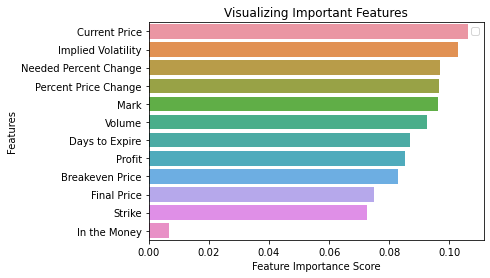

In [54]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [218]:
X = normalized_train1_6_df[['Implied Volatility', 'Days to Expire']]
X7 = normalized_test7_df[['Implied Volatility', 'Days to Expire']]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=5) # 80/20 train/test

In [219]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# prediction on test set
y_pred=clf.predict(X7)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y7, y_pred))

Accuracy: 0.4768296580377117


In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# prediction on test set
y_pred=clf.predict(X7)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y7, y_pred))

Calls: Accuracy: 0.9096314205358464 \
Calls (top6 features (above 0.09)): Accuracy: 0.903858489169586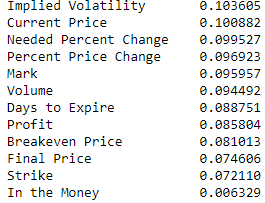

Puts: Accuracy: 0.7065334277546096
Puts (top5 features (above 0.09)): Accuracy: 0.7317124347575209 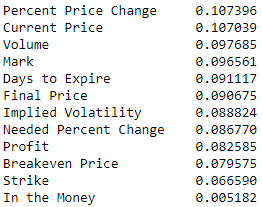

calls (6 week / week): Accuracy: 0.980561555075594
calls (top5): Accuracy: 0.980561555075594 (something is not right)